**Main imports**

In [10]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp
import torch.nn.init as init

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [52]:
# helper function to make getting another batch of data easier

def cycle(iterable):
    while True:
        for x in iterable:
            yield x


batch_size = 2**9        
class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])),
    batch_size=batch_size, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ])),
    batch_size=batch_size, drop_last=True)
print(batch_size)
train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
512
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

**Define a simple model**

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),

        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),

        )
        if stride > 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        return out

class Classifier(nn.Module):
    def __init__(self, params):
        super(Classifier, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(16),
                    )
        self.layer0 = ResidualBlock(16, 32, 1)
        self.layer1 = ResidualBlock(32, 64, 1)
        self.fc1 = nn.Sequential(
                        nn.Conv2d(92, params['n_classes'], kernel_size = 1, stride = 1, padding = 0),
                        nn.BatchNorm2d(params['n_classes']),
                    )
        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.layer0(x)), 2)
        x = F.max_pool2d(F.relu(self.layer1(x)), 2)
        x = self.fc1(x)  # Single FC layer
        x = x.view(x.size(0), -1 )  # Flatten the tensor for the fully connected layer
        
        return x


# Hyperparameters and model instantiation
params = {
    'n_channels': 3,   # number of channels
    'n_classes': 100   # number of classes for CIFAR-100
}

N = Classifier(params).to(device)

# print the number of parameters - this should be included in your report
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.0001, weight_decay=0.0001)
plot_data = []
steps=0
#best acc = 0.333 with batch size 2**7

> Number of parameters 84444


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),

        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),

        )
        if stride > 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        return out

class Classifier(nn.Module):
    def __init__(self, params):
        super(Classifier, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 8, kernel_size = 5, stride = 1, padding = 3),
                        nn.BatchNorm2d(8),
                    )
        self.layer0 = ResidualBlock(8, 16, 1)
        self.layer1 = ResidualBlock(16, 32, 1)
        self.layer2 = nn.Sequential(
                        nn.Conv2d(32, 64, kernel_size= 3, stride=1, padding= 1),
                        nn.BatchNorm2d(64),
                    )#ResidualBlock(64, 92, 1)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64, 92, kernel_size= 3, stride=1, padding= 1),
                        nn.BatchNorm2d(92)
                    )
        #at this stage data in 64 x 2 x 2 shape. 
        self.layer4 = nn.Sequential(
                        nn.Conv2d(92, params['n_classes'], kernel_size = 1, stride = 1, padding = 0),
                        nn.BatchNorm2d(params['n_classes']),
                    )



        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.layer0(x)), 2)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.avg_pool2d(F.relu(self.layer4(x)), x.size()[2:])
        x = x.view(x.size(0), -1)
        return x
    
    #use HE init as it works the best for ReLU
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                init.zeros_(m.bias)

# Hyperparameters and model instantiation
params = {
    'n_channels': 3,   # number of channels
    'n_classes': 100   # number of classes for CIFAR-100
}

N = Classifier(params).to(device)
N.initialize_weights()
# print the number of parameters - this should be included in your report
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.0001, weight_decay=0)
plot_data = []
steps=0
#best acc = 0.324 with batch size 2**8

> Number of parameters 100368
> Warning: you have gone over your parameter budget and will have a grade penalty!


**Main training and testing loop**

steps: 10000.00, train loss: 2.543, train acc: 0.417±0.023, test acc: 0.371±0.020


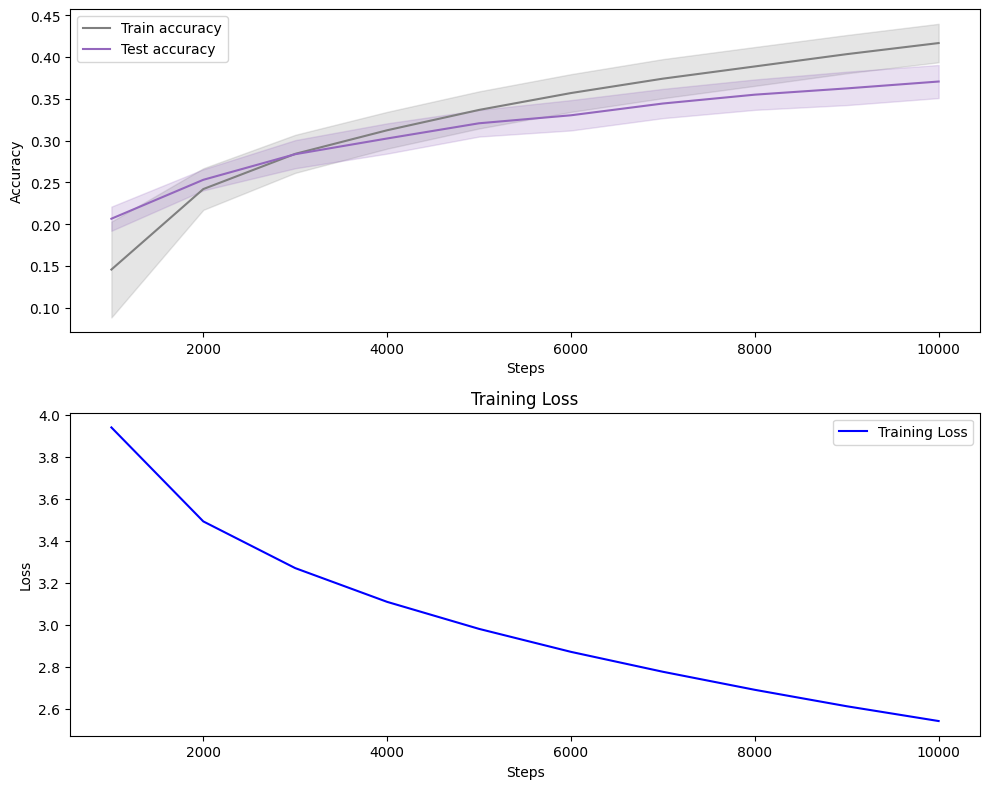

In [55]:
# keep within our optimisation step budget
loss_data = []
while (steps < 10000):

    # arrays for metrics
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate through some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()
        steps += 1

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # iterate over the entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)
        p = N(x)
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # print your loss and accuracy data - include this in the final report
    print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(
        steps, train_loss_arr.mean(),train_acc_arr.mean(),train_acc_arr.std(),test_acc_arr.mean(),test_acc_arr.std()))
    loss_data.append([steps, train_loss_arr.mean()])
    # Plotting both the training loss and accuracy
    # Plotting both the training loss and accuracy
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # plot your accuracy graph - add a graph like this in your final report
    plot_data.append([steps, np.array(train_acc_arr).mean(), np.array(train_acc_arr).std(), np.array(test_acc_arr).mean(), np.array(test_acc_arr).std()])
    reward_list = []
    ax1.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    ax1.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
    ax1.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    ax1.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc="upper left")
    ax2.plot([x[0] for x in loss_data], [x[1] for x in loss_data], label='Training Loss', color='blue')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss')
    ax2.legend()
    plt.tight_layout()

    plt.show()
    disp.clear_output(wait=True)

## **Inference on dataset**

This is useful for analysis but is entirely optional

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(100), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())

### here I will store models for comparisons

In [ ]:
#deep Net with 6 conv layers 
import torch.nn.init as init

class Classifier(nn.Module):
    def __init__(self, params):
        super(Classifier, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm2d(8)  # Batch normalization for conv1
        self.conv2 = nn.Conv2d(8, 20, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(20)  # Batch normalization for conv2
        self.conv3 = nn.Conv2d(20, 40, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(40)  # Batch normalization for conv3
        self.conv4 = nn.Conv2d(40, 43, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(43)  # Batch normalization for conv4
        self.conv5 = nn.Conv2d(43, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)  # Batch normalization for conv5
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)  # Batch normalization for conv6

        # Fully connected layers
        self.fc1 = nn.Linear(64*2*2, params['n_hidden'])
        self.fc2 = nn.Linear(params['n_hidden'], params['n_classes'])

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), 2)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), 2)
        x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), 2)
        x = x.view(-1, 64 * 2 * 2)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                init.zeros_(m.bias)

# Hyperparameters and model instantiation
params = {
    'n_channels': 3,   # number of channels
    'n_hidden': 30,    # hidden units
    'n_classes': 100   # number of classes for CIFAR-100
}

N = Classifier(params).to(device)
N.initialize_weights()

# print the number of parameters - this should be included in your report
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.0001, weight_decay=0.01)
plot_data = []
steps = 0
#best acc is 0.306, batch size = 2**7

In [36]:
class DSC(nn.Module):
    '''https://arxiv.org/pdf/1704.04861.pdf
    depthwise seperable convolution. 
    a seperate conv is applied to each channel this is done using 
    groups = channels_in,
    then a pointwise is used to generate new channels
    '''
    
    def __init__(self, chan_in, chan_out, k=3, stride=1, pad=1):
        super(DSC, self).__init__()
        self.depthwise = nn.Sequential(nn.Conv2d(chan_in, chan_in, kernel_size = k, stride=stride, padding=pad, groups=chan_in),
                                      nn.BatchNorm2d(chan_in),
                                      nn.ReLU())
        
        self.pointwise = nn.Sequential(nn.Conv2d(chan_in, chan_out, kernel_size = 1, stride=1, padding=0),
                                      nn.BatchNorm2d(chan_out))
                                      
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
       
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = DSC(in_channels, in_channels)
        
        self.conv2 = DSC(in_channels, out_channels)
            

        
        if stride > 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        return out

class Classifier(nn.Module):
    def __init__(self, params):
        super(Classifier, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size = 5, stride = 1, padding = 2),
                        nn.BatchNorm2d(32),
                    )
        self.layer0 = ResidualBlock(32,64, 1)
        self.layer1 = ResidualBlock(64, 256, 1) 
        self.layer5 = nn.Sequential(
                        nn.Conv2d(256, params['n_classes'], kernel_size = 1, stride = 1, padding = 0),
                        nn.BatchNorm2d(params['n_classes']))



        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.layer0(x)), 2)
        x = F.relu(self.layer1(x))
        x = F.avg_pool2d((self.layer5(x)), x.size()[2:])
        x = x.view(x.size(0), -1)
        return x
    #use HE init as it works the best for ReLU
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                init.zeros_(m.bias)
# Hyperparameters and model instantiation
params = {
    'n_channels': 3,   # number of channels
    'n_hidden': 30,    # hidden units
    'n_classes': 100   # number of classes for CIFAR-100
}

N = Classifier(params).to(device)
N.initialize_weights()

# print the number of parameters - this should be included in your report
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.0001, weight_decay=0.01)
plot_data = []
steps = 0       

> Number of parameters 74892


In [54]:
#MobileNet architecture

class DSC(nn.Module):
    '''https://arxiv.org/pdf/1704.04861.pdf
    depthwise seperable convolution. 
    a seperate conv is applied to each channel this is done using 
    groups = channels_in,
    then a pointwise is used to generate new channels
    '''
    
    def __init__(self, chan_in, chan_out, k=3, stride=1, pad=1):
        super(DSC, self).__init__()
        self.depthwise = nn.Sequential(
            nn.Conv2d(chan_in, chan_in, kernel_size = k, stride=stride, padding=pad, groups=chan_in),
            nn.BatchNorm2d(chan_in),
            nn.ReLU()
        )
        self.pointwise = nn.Sequential(
            nn.Conv2d(chan_in, chan_out, kernel_size = 1, stride=1, padding=0),
            nn.BatchNorm2d(chan_out),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
       
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            DSC(in_channels, out_channels),
            nn.BatchNorm2d(out_channels)
        )
        self.conv2 = nn.Sequential(
            DSC(out_channels, out_channels),
            nn.BatchNorm2d(out_channels),

        )
        if stride > 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        return out

class Classifier(nn.Module):
    def __init__(self, params, alpha):
        super(Classifier, self).__init__()
        self.input = nn.Sequential(
                        nn.Conv2d(3, int(64 * alpha), kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(int(64 * alpha)),
                    ) #uses step 2 instead of pooling
        self.layer0 = DSC(int(64* alpha),int(256* alpha)) 
        self.layer1 = DSC(int(256* alpha),int(512* alpha)) 

        


        #use a 1x1 convolution and average pooling to generate an output
        #replaces a standard linear layer
        self.out = nn.Sequential(
                        nn.Conv2d(int(512* alpha), params['n_classes'], kernel_size = 1, stride = 1, padding = 0),
                        nn.BatchNorm2d(params['n_classes']),
                    )



        
        
    def forward(self, x):
        x = self.input(x)
        x = F.max_pool2d(self.layer0(x),2)
        x = F.max_pool2d(self.layer1(x),2)
        
        

        x = F.avg_pool2d((self.out(x)), x.size()[2:])
        x = x.view(x.size(0), -1)
        return x
    #use HE init as it works the best for ReLU
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                init.zeros_(m.bias)
# Hyperparameters and model instantiation
params = {
    'n_channels': 3,   # number of channels
    'n_hidden': 30,    # hidden units
    'n_classes': 100   # number of classes for CIFAR-100
}

N = Classifier(params, 0.62).to(device)
N.initialize_weights()

# print the number of parameters - this should be included in your report
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.0001, weight_decay=0)
plot_data = []
steps = 0       

> Number of parameters 93207
